# causalBootstrapping: Tutorial 01

A series of tutorials demonstrating the use of the causalBootstrapping library.

### Backdoor

Backdoor scenario assumes there is a confounder performing as a common cause of both the cause and the effect variables. In this demonstration, we suppose $U$ is the confounder, $Y$ is the cause and $X$ is the effect.


This tutorial mainly focuses on illustrating the use of backdoor causal bootstrapping interfaces: `backdoor_simple()` and `backdoor_simu()`.

In [1]:
import causalBootstrapping as cb
from distEst_lib import MultivarContiDistributionEstimator
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

#### Discrete intervention - using backdoor_simple()

`backdoor_simple()` is an interface to perform backdoor causal bootstrapping using the provided observational data and distribution maps. This function bootstraps the given observational data by taking all the existing values in the cause variable as interventional values. It generates the same sample size with respect to the cause variable.

*1. Read the demo. data*

In [2]:
testdata_dir = "../test_data/frontdoor_discY_contZ_contX_discU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv")
Y_train = pd.read_csv(testdata_dir + "Y_train.csv")
U_train = pd.read_csv(testdata_dir + "U_train.csv")

*2. Assign the key-value pair for each variable*

In [3]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
U_train = np.array(U_train)

cause_data = {"Y": Y_train}
effect_data = {"X": X_train}
confounder_data = {"U": U_train}

*3. Estimate distributions which will be used to calculate the causal bootstrapping weights*

In backdoor causal bootstrapping, the weight function is:

$w_n = \frac{P(u_n)*K[y_n, y]}{P(y_n, u_n)}$,

where $K[.]$ is a kernel function, $y_n$ and $u_n$ are the n-th observed instance for variable $Y$ and $U$, $y$ is the interventional value for the cause variable.

In the demo. example, we assume that the distribution of $P(Y|U)$ is unknown, but can be easily estimated from the observational dataset. That is,

$P(Y|U) \approx \hat P(Y|U)$

Therefore, we should estimate the distributions of $P(Y,U)$ and $P(U)$. In practice, we enourge the user to define the distribution's PMF/PDF if it is accessible.

In [4]:
# Because U and Y are discrete, we input the number of bins for histogram estimation for each variable with 0
# That means that the histogram estimation will use the unique values of each variable as bins
n_bins_yu = [0, 0, 0]
n_bins_u = [0, 0]
joint_yu_data = np.concatenate((Y_train.reshape(-1,1), U_train), axis = 1)

dist_estimator_yu = MultivarContiDistributionEstimator(data_fit=joint_yu_data, n_bins = n_bins_yu)
pdf_yu, pyu = dist_estimator_yu.fit_histogram()
dist_estimator_u = MultivarContiDistributionEstimator(data_fit=U_train, n_bins = n_bins_u)
pdf_u, pu = dist_estimator_u.fit_histogram()

*4. Construct the distribution mapping dictionary*

In [5]:
dist_map = {"Y,U": lambda Y, U: pdf_yu([Y,U]),
            "U": lambda U: pdf_u(U)}

*5. Use $backdoor\_simple()$ to perform backdoor causal bootstrapping*

For categorical interventions, we simply choose the kernel function $K[y_n, y] = \delta(y_n-y)$. It can be other appropriate kernels if needed.

In [6]:
cb_data = cb.backdoor_simple(cause_data, effect_data, confounder_data, dist_map)

*6. Compare the boostrapping results with the original dataset*

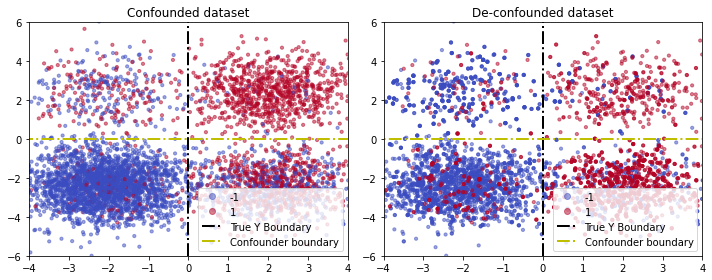

In [7]:
# The original confounded dataset
fig,axs=plt.subplots(1, 2 , figsize=(10,4))
scatter = axs[0].scatter(x= np.array(X_train)[:,0], y = np.array(X_train)[:,1], c = np.array(Y_train), s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter1, labels_scatter1 = scatter.legend_elements(prop="colors")

true_b1 = axs[0].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder1 = axs[0].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[0].legend(handles=handles_scatter1+true_b1+confounder1, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-6,6)
axs[0].set_title("Confounded dataset")

# The bootstrapped de-confounded dataset
scatter = axs[1].scatter(x= np.array(cb_data["X"])[:,0], y = np.array(cb_data["X"])[:,1], c = np.array(cb_data["intv_Y"]),  s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter2, labels_scatter2 = scatter.legend_elements(prop="colors")

true_b2 = axs[1].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder2 = axs[1].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[1].legend(handles=handles_scatter2+true_b2+confounder2, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-6,6)
axs[1].set_title("De-confounded dataset")

plt.tight_layout()
plt.show()

*7. Train two linear Support Vector Classifiers (SVC) using the original confounded dataset and the bootstrapped dataset and compare thier performance on un-confounded test set*

In [8]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=5)
clf_cb.fit(cb_data['X'], cb_data['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv")
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       386
           2       0.89      0.82      0.85       614

    accuracy                           0.83      1000
   macro avg       0.82      0.83      0.82      1000
weighted avg       0.83      0.83      0.83      1000



*8. Draw the decision boundaries for the two SVCs and the un-confounded test set*

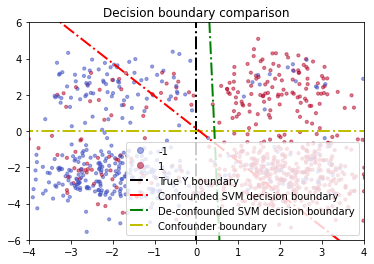

In [9]:
# Compute the decision boundary of the two models
weight_conf = clf_conf.coef_[0]
bias_conf = clf_conf.intercept_[0]
k_conf = -weight_conf[0] / weight_conf[1]
b_conf = -bias_conf / weight_conf[1]
x_conf = np.linspace(-4, 4, 100)
decison_boundary_conf = k_conf * x_conf + b_conf

weight_deconf = clf_cb.coef_[0]
bias_deconf = clf_cb.intercept_[0]
k_deconf = -weight_deconf[0] / weight_deconf[1]
b_deconf = -bias_deconf / weight_deconf[1]
x_deconf = np.linspace(-4, 4, 100)
decison_boundary_deconf = k_deconf * x_deconf + b_deconf

# Plot the decision boundary of the two models and the scatter plot of the test set
fig,ax=plt.subplots()
scatter = ax.scatter(x= X_test[:,0], y = X_test[:,1], c = Y_test, s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")

plt.xlim(-4,4)
plt.ylim(-6,6)
x_ = np.linspace(-4, 4, 100)

true_b = plt.plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder = plt.plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")
clf_b_conf = plt.plot(x_, decison_boundary_conf, '-.r', linewidth = 2, label= 'Confounded SVM decision boundary')
clf_b_deconf = plt.plot(x_, decison_boundary_deconf, '-.g', linewidth = 2, label= 'De-confounded SVM decision boundary')

ax.legend(handles=handles_scatter+true_b+clf_b_conf+clf_b_deconf+confounder, labels=['-1','1','True Y boundary','Confounded SVM decision boundary', 'De-confounded SVM decision boundary', 'Confounder boundary'], loc='lower right')

plt.title('Decision boundary comparison')
plt.show()

#### Continous intervention - using backdoor_simu()

`backdoor_simu()` is an interface to perform backdoor causal bootstrapping using the provided observational data, distribution maps and intended interventional values. This function bootstraps the given observational data by taking the values defined by the user as interventional values. It does not have to generate the same sample size with respect to the cause variable, but the user can define the sample size for each interventional value.

*1. Read the demo. data*

In [10]:
testdata_dir = "../test_data/backdoor_contY_contX_contU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv")
Y_train = pd.read_csv(testdata_dir + "Y_train.csv")
U_train = pd.read_csv(testdata_dir + "U_train.csv")

*2. Assign the key-value pair for each variable*

In [11]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
U_train = np.array(U_train)

cause_data = {"Y": Y_train}
effect_data = {"X": X_train}
confounder_data = {"U": U_train}
N = Y_train.shape[0]

*3. Estimate distributions which will be used to calculate the causal bootstrapping weights*

In this example, Kernel Density Estimation (KDE) is used to estimate the intended distributions, instead of histogram estimation.

In [12]:
joint_yu_data = np.concatenate((Y_train.reshape(-1,1), U_train), axis = 1)
dist_est_bin_num = 50
n_bins_yu = [dist_est_bin_num,dist_est_bin_num]
n_bins_u = [dist_est_bin_num]

dist_estimator_yu = MultivarContiDistributionEstimator(data_fit=joint_yu_data, n_bins = n_bins_yu)
pdf_yu, pyu = dist_estimator_yu.fit_kde()
dist_estimator_u = MultivarContiDistributionEstimator(data_fit=U_train, n_bins = n_bins_u)
pdf_u, pu = dist_estimator_u.fit_kde()

*4. Construct the distribution mapping dictionary*

The distribution mapping dictionary should be formed with keys as the random variable names for the corresponding distribution and values as a `lambda` function of the PDF/PMF.

In [13]:
dist_map = {"Y,U": lambda Y, U: pdf_yu([Y,U]),
            "U": lambda U: pdf_u(U)}

*5. Use $backdoor\_simu()$ to perform backdoor causal bootstrapping*

In this example, we simply define the interventional values with the same range of the cause variable and the evenly interval. Because the interventional values are continous, we consider to use the Gaussian kernel in this demonstration, which is $K[y_n, y] = {e^{ - \frac{{||y - {y_n}|{|^2}}}{{2{\sigma ^2}}}}}$, where $\sigma^2$ is the kernel width.

In [14]:
intv_intval_num = 100
kernel_width = 2
Y_interv_values = np.linspace(np.min(Y_train), np.max(Y_train), intv_intval_num)

cb_data_simu = {}
for i, interv_value in enumerate(Y_interv_values):
    cb_data = cb.backdoor_simu(cause_data = cause_data, 
                               effect_data = effect_data, 
                               confounder_data = confounder_data, 
                               dist_map = dist_map, 
                               intv_value = [interv_value for i in range(N)], 
                               n_sample = int(N/intv_intval_num), 
                               kernel_intv = lambda Y, intv_Y: norm.pdf(Y-intv_Y, 0, kernel_width))
    for key in cb_data:
        if i == 0:
            cb_data_simu[key] = cb_data[key]
        else:
            cb_data_simu[key] = np.vstack((cb_data_simu[key], cb_data[key]))

*6. Compare the boostrapping results with the original dataset*

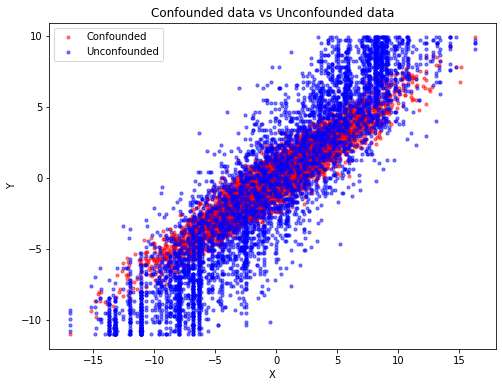

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train, Y_train, alpha=0.5, color='red', label='Confounded', s=10)
plt.scatter(cb_data_simu["X"], cb_data_simu["intv_Y"], alpha=0.5, color='blue', label='Unconfounded', s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Confounded data vs Unconfounded data')
plt.legend()
plt.show()

*7. Train two linear Support Vector Regressors (SVR) using the original confounded dataset and the bootstrapped dataset and compare thier performance on un-confounded test set*

In [16]:
## Train two linear support vector machines using confounded and de-confounded datasets
reg_cb = svm.SVR(kernel = "linear", C=2)
reg_cb.fit(cb_data_simu['X'], cb_data_simu['intv_Y'].reshape(-1))

reg_conf = svm.SVR(kernel = "linear", C=2)
reg_conf.fit(X_train, Y_train.reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir + "X_test.csv")
Y_test = pd.read_csv(testdata_dir + "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

pred_cb = reg_cb.predict(X_test)
mse_cb = mean_squared_error(Y_test, pred_cb)
mae_cb = mean_absolute_error(Y_test, pred_cb)
mape_cb = mean_absolute_percentage_error(Y_test, pred_cb)
r2_cb = r2_score(Y_test, pred_cb)
print("Report of deconfonded model:")
print("MSE: %.4f" %(mse_cb))
print("MAE: %.4f" %(mae_cb))
print("MAPE: %.4f" %(mape_cb))
print("R-squared: %.4f" %(r2_cb))

pred_conf = reg_conf.predict(X_test)
mse_conf = mean_squared_error(Y_test, pred_conf)
mae_conf = mean_absolute_error(Y_test, pred_conf)
mape_conf = mean_absolute_percentage_error(Y_test, pred_conf)
r2_conf = r2_score(Y_test, pred_conf)
print("Report of confonded model:")
print("MSE: %.4f" %(mse_conf))
print("MAE: %.4f" %(mae_conf))
print("MAPE: %.4f" %(mape_conf))
print("R-squared: %.4f" %(r2_conf))

Report of deconfonded model:
MSE: 0.5963
MAE: 0.6124
MAPE: 0.5927
R-squared: 0.9621
Report of confonded model:
MSE: 2.7423
MAE: 1.3123
MAPE: 0.6487
R-squared: 0.8258


*8. Draw the regression hyperplains for the two SVRs and the un-confounded test set*

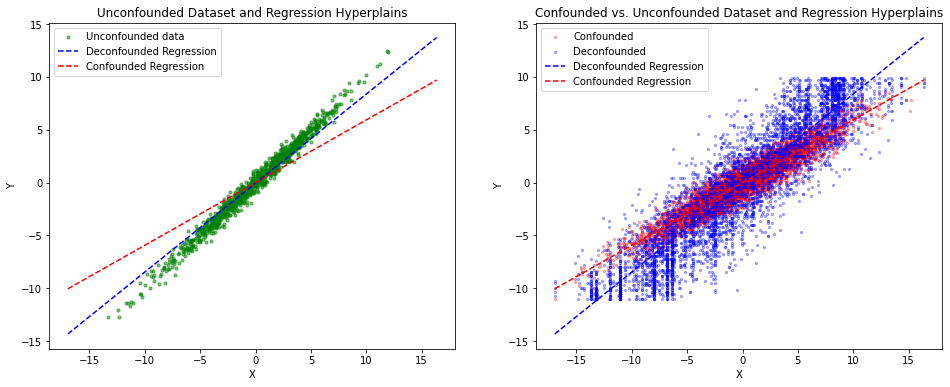

In [17]:
# Compute the regression hyperplains
x_grid = np.linspace(np.min(X_train),np.max(X_train), num=100)
reg_y_cb = reg_cb.predict(x_grid.reshape(-1,1))
reg_y_conf = reg_conf.predict(x_grid.reshape(-1,1))

fig,axs=plt.subplots(1, 2 , figsize=(16,6))
# Plot the unconfounded test data
axs[0].scatter(X_test, Y_test, alpha=0.5, color='green', label='Unconfounded data', s=10)
# Plot the regression hyperplain
axs[0].plot(x_grid, reg_y_cb, 'b--', label='Deconfounded Regression')
axs[0].plot(x_grid, reg_y_conf, 'r--', label='Confounded Regression')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Unconfounded Dataset and Regression Hyperplains')
axs[0].legend()

# Plot the deconfounded and confounded training data
axs[1].scatter(X_train, Y_train, alpha=0.3, color='red', label='Confounded', s=5)
axs[1].scatter(cb_data_simu["X"], cb_data_simu["intv_Y"], alpha=0.3, color='blue', label='Deconfounded', s=5)
# Plot the regression hyperplain
axs[1].plot(x_grid, reg_y_cb, 'b--', label='Deconfounded Regression')
axs[1].plot(x_grid, reg_y_conf, 'r--', label='Confounded Regression')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_title('Confounded vs. Unconfounded Dataset and Regression Hyperplains')
axs[1].legend()
plt.show()